In [10]:
import warnings, os, datetime, zipfile, tqdm, gdown, glob, random, shutil, pytz
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [11]:
timezone = pytz.timezone('Europe/Paris')
now = datetime.datetime.now(timezone).strftime('%Y.%m.%d-%H.%M.%S')

project_path = os.getcwd()

paths = {
    "data_path": f"{project_path}/data",
    "train_data_path": f"{project_path}/data/train",
    "validation_data_path": f"{project_path}/data/validation",
    "unsorted_validation_data_path": f"{project_path}/data/validation/unsorted",
    "sorted_validation_data_path": f"{project_path}/data/validation/sorted",
    "model_path": f"{project_path}/models",
    "checkpoint_path": f"{project_path}/weights/model_early",
    "log_path": f"{project_path}/logs/fit/{now}_model"
}

paths_to_delete = [
    "unsorted_validation_data_path",
    "sorted_validation_data_path"
]

for key, path in paths.items():
    if key in paths_to_delete and os.path.exists(path):
        print(f"Deleting {path}")
        shutil.rmtree(path)
    os.makedirs(path, exist_ok=True)

image_h = 224
image_w = 224
batch_s = 32

encoding_dim = 256

Deleting c:\Users\Kylian\Documents\Projet\ia\ProjetDeepLearning\livrable_2/data/validation/unsorted
Deleting c:\Users\Kylian\Documents\Projet\ia\ProjetDeepLearning\livrable_2/data/validation/sorted


In [12]:
def download_dataset(force=False):
    # Construct the dataset path
    dataset_path = os.path.join(paths['train_data_path'], 'dataset_livrable_2.zip')

    # Check if the dataset is already downloaded
    if os.path.exists(dataset_path) and not force:
        print("Dataset is already downloaded.")
    else:
        print("Downloading dataset...")
        url = 'https://drive.google.com/uc?export=download&id=1WdcW_OqvRyuLiGx0FiZR0KmrqB9VYsLw'
        gdown.download(url, dataset_path, quiet=False)
    
    # Check if the dataset is already extracted
    if len(os.listdir(paths['train_data_path'])) == 2 and not force:
        print("Dataset is already extracted.")
    else:
        print("Extracting dataset...")
        with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
            files = zip_ref.infolist()
            with tqdm.tqdm(total=len(files), desc="Extracting", unit="file") as pbar:
                for file in files:
                    zip_ref.extract(file, paths['train_data_path'])
                    pbar.update(1)
            print(f"Dataset extracted to {paths['train_data_path']}")
        
# Call the function
download_dataset()

Dataset is already downloaded.
Dataset is already extracted.


In [13]:
def check_images_in_dataset(dataset_path):
    # Get the paths of all image files (jpg, png, etc.)
    img_paths = glob.glob(os.path.join(dataset_path, '*/*.*'))  # You can specify extensions like '*.jpg' if necessary

    for img_path in tqdm.tqdm(img_paths, desc="Checking images"):
        try:
            # Read and decode the image to check if it is valid
            img_bytes = tf.io.read_file(img_path)
            tf.io.decode_image(img_bytes)

        except tf.errors.InvalidArgumentError as e:
            # Catch specific TensorFlow error and remove bad files
            print(f"Found corrupt image: {img_path}. Error: {str(e)}. Removing it.")
            os.remove(img_path)
        except Exception as e:
            # General exception handler for other possible issues
            print(f"Error processing image: {img_path}. Error: {str(e)}. Removing it.")
            os.remove(img_path)

# Call the function to check the images in the train data path
#check_images_in_dataset(paths['train_data_path'])


In [14]:
train_set, test_set = tf.keras.preprocessing.image_dataset_from_directory(
    paths['train_data_path'],
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(image_h, image_w),
    batch_size=batch_s,
    labels=None,
    label_mode=None
)

Found 4982 files.
Using 3986 files for training.
Using 996 files for validation.


Remarque sympa de notre ami le chat : 

Distribution du bruit : Si tu souhaites tester d'autres types de bruit, tu pourrais explorer différentes distributions (par exemple du bruit impulsionnel ou du bruit Poisson) en plus du bruit gaussien pour diversifier encore plus les perturbations appliquées aux images.

In [15]:
# Ajout de la couche de redimensionnement
rescale_layer = tf.keras.layers.Rescaling(1./255)


def add_gaussian_noise(images, min_noise=0.3, max_noise=0.6):
    batch_size = tf.shape(images)[0]
    noise_factor = tf.random.uniform(shape=(batch_size, 1, 1, 1), minval=min_noise, maxval=max_noise)
    noise = tf.random.normal(shape=tf.shape(images))
    noisy_images = images + noise_factor * noise
    noisy_images = tf.clip_by_value(noisy_images, 0.0, 1.0)
    return noisy_images

# Création des datasets avec bruit
noisy_train_set = train_set.map(
    lambda x: (add_gaussian_noise(rescale_layer(x)), rescale_layer(x)),
    num_parallel_calls=tf.data.AUTOTUNE
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)


noisy_test_set = test_set.map(
    lambda x: (add_gaussian_noise(rescale_layer(x)), rescale_layer(x)),
    num_parallel_calls=tf.data.AUTOTUNE
).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

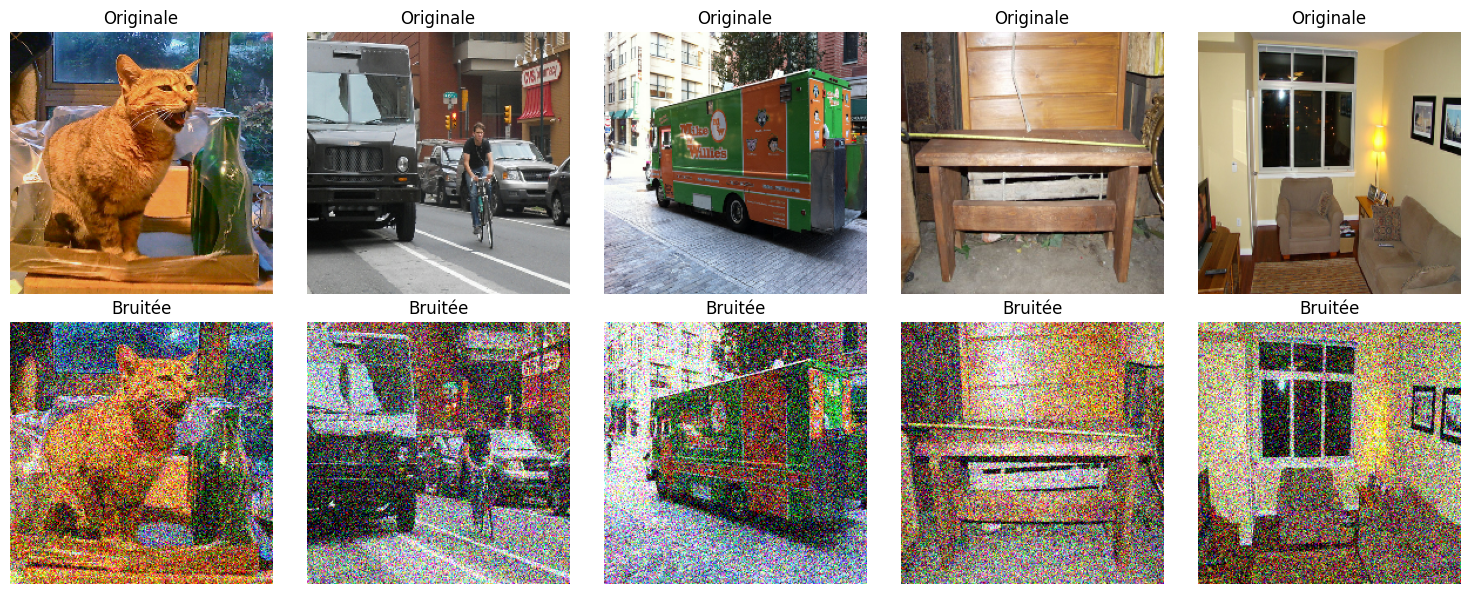

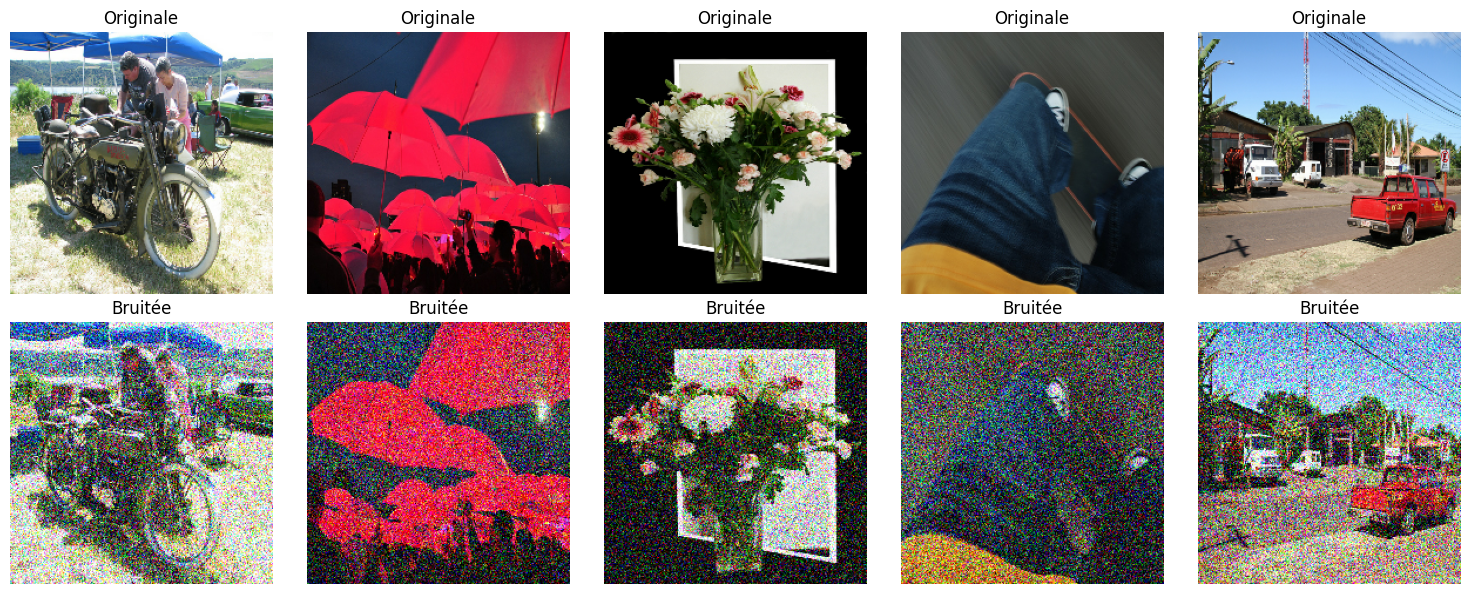

In [16]:
# Fonction pour afficher les images originales et bruitées
def display_noisy_train_images(noisy_dataset, num_images=5):
    plt.figure(figsize=(15, 6))

    for noisy_images, original_images in noisy_dataset.take(1):
        for i in range(num_images):
            # Image originale
            plt.subplot(2, num_images, i + 1)
            plt.imshow(original_images[i].numpy())
            plt.title('Originale')
            plt.axis('off')

            # Image bruitée
            plt.subplot(2, num_images, num_images + i + 1)
            plt.imshow(noisy_images[i].numpy())
            plt.title('Bruitée')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

display_noisy_train_images(noisy_train_set, num_images=5)
display_noisy_train_images(noisy_test_set, num_images=5)

In [17]:
def build_autoencoder(input_shape):
    input_img = tf.keras.layers.Input(shape=input_shape)
    
    # **Encodeur**
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    
    encoded = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)

    # **Décodeur**
    x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)
    
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)

    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.UpSampling2D((2, 2))(x)

    decoded = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    # **Modèle auto-encodeur**
    autoencoder = tf.keras.Model(input_img, decoded)
    return autoencoder

# **Construction du modèle**
input_shape = (image_h, image_w, 3)
autoencoder = build_autoencoder(input_shape)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 56, 56, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 112, 112, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 224, 224, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# **Définition des callbacks**
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# **Entraînement du modèle**
history = autoencoder.fit(
    noisy_train_set,
    epochs=50,
    validation_data=noisy_test_set,
    callbacks=[early_stopping]
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 64s 497ms/step - loss: 0.5900 - val_loss: 0.5333
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 78s 620ms/step - loss: 0.5349 - val_loss: 0.5271
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 61s 487ms/step - loss: 0.5304 - val_loss: 0.5270
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 76s 603ms/step - loss: 0.5285 - val_loss: 0.5236
Epoch 5/50
 34/125 ━━━━━━━━━━━━━━━━━━━━ 54s 597ms/step - loss: 0.5244

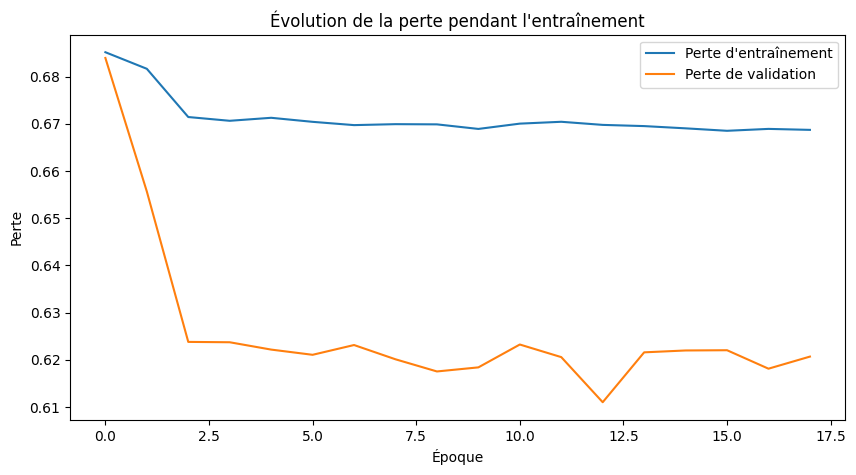

In [28]:
# **Tracer les courbes de perte**
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.title('Évolution de la perte pendant l\'entraînement')
plt.legend()
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


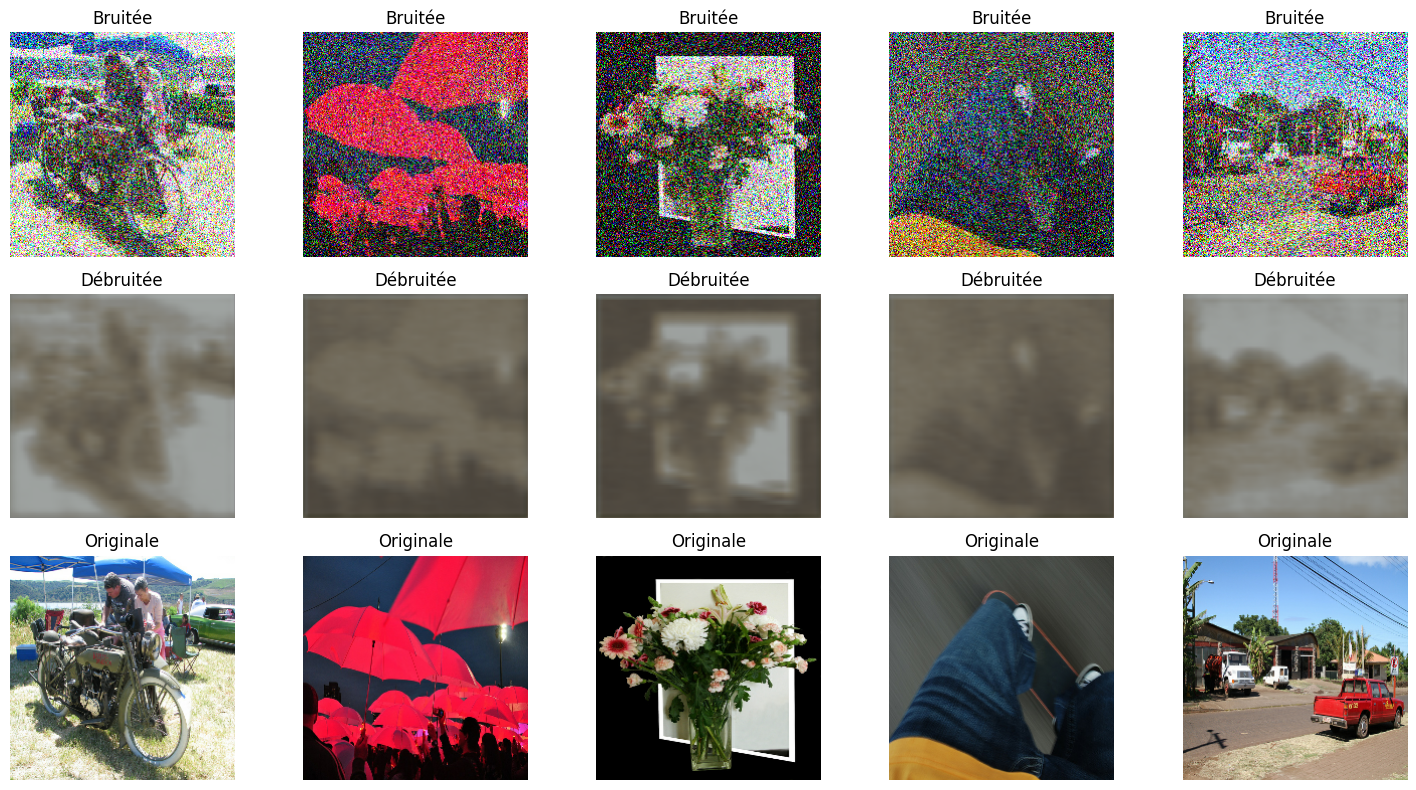

In [29]:
def display_denoised_images(model, dataset, num_images=5):
    plt.figure(figsize=(15, 8))

    for noisy_images, original_images in dataset.take(1):
        # Prédire les images débruitées
        denoised_images = model.predict(noisy_images)
        
        for i in range(num_images):
            # **Image bruitée**
            plt.subplot(3, num_images, i + 1)
            plt.imshow(noisy_images[i].numpy())
            plt.title('Bruitée')
            plt.axis('off')
            
            # **Image débruitée**
            plt.subplot(3, num_images, num_images + i + 1)
            plt.imshow(denoised_images[i])
            plt.title('Débruitée')
            plt.axis('off')
            
            # **Image originale**
            plt.subplot(3, num_images, 2 * num_images + i + 1)
            plt.imshow(original_images[i].numpy())
            plt.title('Originale')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# **Affichage des résultats**
display_denoised_images(autoencoder, noisy_test_set, num_images=5)